## Package Import 

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

## Load Dataset

### Load dataset from Keras

In [15]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()


In [16]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

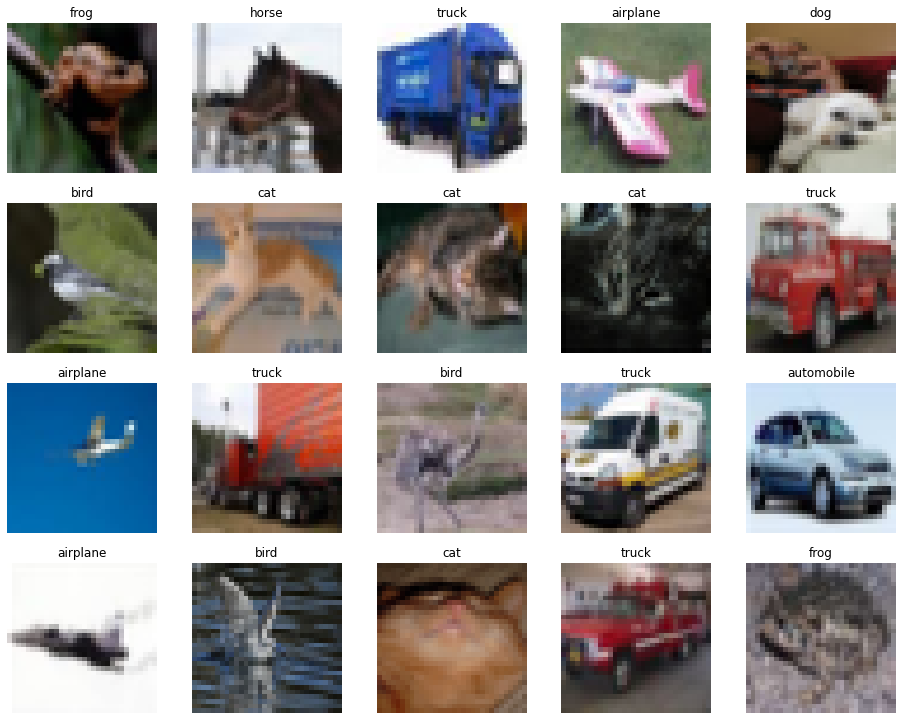

In [17]:
label_str = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(16, 16))
for i,(image,label) in enumerate(train_ds.take(20)):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(label_str[label.numpy()[0]])
    plt.axis('off')

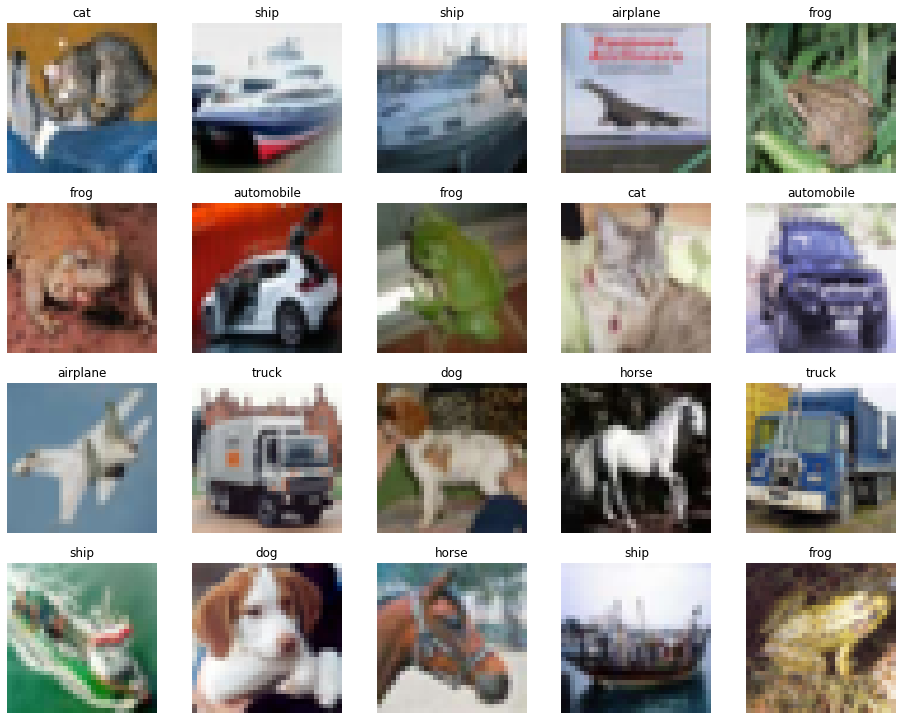

In [18]:
plt.figure(figsize=(16, 16))
for i,(image,label) in enumerate(test_ds.take(20)):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(label_str[label.numpy()[0]])
    plt.axis('off')

In [19]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 64x64
    image = tf.image.resize(image, (64, 64))
    return image, label

In [20]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Train size:", train_ds_size)
print("Test size:", test_ds_size)
print("Validation size:", validation_ds_size)

Train size: 45000
Test size: 10000
Validation size: 5000


In [ ]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(4096, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(4096, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation='softmax')
# ])

## AlexNet

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
])

In [ ]:
# root_logdir = os.path.join(os.curdir, "logs\\fit\\")
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)
# run_logdir = get_run_logdir()
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[])

## ResNet

### Define Residual Unit

In [ ]:
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

def lr_scheduler(epoch, lr):
    new_lr = lr * (0.1 ** (epoch // 50))
    print('new lr:%.2e' % new_lr)
    return new_lr 

reduce_lr = LearningRateScheduler(lr_scheduler)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

In [ ]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
from keras.utils import np_utils



Y_train = np_utils.to_categorical(train_labels, 10)
Y_test = np_utils.to_categorical(validation_labels, 10)

X_train = train_images.astype('float32')
X_test =  validation_images.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

### ResNet-18

In [ ]:
rn18 = keras.models.Sequential()
rn18.add(DefaultConv2D(64, kernel_size=7, strides=2,input_shape=(32,32,3)))
rn18.add(keras.layers.BatchNormalization())
rn18.add(keras.layers.Activation("relu"))
rn18.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 2 + [128] * 2 + [256] * 2 + [512] * 2:
    strides = 1 if filters == prev_filters else 2
    rn18.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
rn18.add(keras.layers.GlobalAvgPool2D())
rn18.add(keras.layers.Flatten())
rn18.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
rn18.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
rn18.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                   steps_per_epoch=X_train.shape[0],
                    validation_data=(X_test, Y_test),
                    epochs=200,
#                     verbose=2,
                    callbacks=[reduce_lr])

### ResNet-34

In [ ]:
rn34 = keras.models.Sequential()
rn34.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
rn34.add(keras.layers.BatchNormalization())
rn34.add(keras.layers.Activation("relu"))
rn34.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    rn34.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
rn34.add(keras.layers.GlobalAvgPool2D())
rn34.add(keras.layers.Flatten())
rn34.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
rn34.summary()

In [ ]:
rn18.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
rn18.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                    steps_per_epoch=X_train.shape[0],
                    validation_data=validation_ds,
                    epochs=200,
                    verbose=2,
                    callbacks=[reduce_lr])